<a href="https://colab.research.google.com/github/minami-cs/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/90

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,065 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121703 files and dire

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)

        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)

                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')

                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/" # 프랑스 패션 사이트의 RSS 데이터 이용
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [3]:
from IPython.display import display, HTML   # img 태그로 만들어서 이미지를 보기 위해 임포트

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [4]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer   # pytorch를 감싼 transformer 이용

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True) # 허깅페이스에 있는 모델 사용 - int4로 양자화된 모델 (int는 경량화된 모델)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [5]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer) # 이미지가 메시지에 포함되므로 image=None 설정
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [11]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = "how many cats in the photo? including the book's cover."
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result) # 흠... 2가 아니네...

1


In [9]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [12]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

yes
No.
yes
yes
yes
yes
no
yes
no
yes
yes
yes


## 14-6 의류 판단 결과 시각화

In [13]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,False
2,,True
3,,True
4,,True
5,,True
6,,False
7,,True
8,,False
9,,True


## 14-7 의류 이미지 필터링

In [15]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]  # boolean indexing 이용

## 14-8 의류 스타일 분석

In [17]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    # 한국어를 잘하는 경량 VLM이 존재하지 않아서 질문을 영어로 작성해야 함ㅠ
    question = 'Analyze the style of the clothes. Explain the color and the trend change.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

In [18]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The clothing style depicted in the image leans towards a minimalist and casual aesthetic, characterized by neutral tones and simple cuts. The use of beige shorts paired with grey cardigans suggests a preference for understated elegance over bold fashion statements. This could be indicative of a trend that favors comfort without sacrificing style, possibly influenced by contemporary fashion trends that emphasize versatility and timeless pieces.\n\nThe color palette is predominantly earthy and muted, which can be associated with a modern, laid-back vibe often seen in streetwear and casual-chic looks. Such colors are not only versatile but also easy to pair, reflecting a practical approach to wardrobe building. The choice of materials, such as what appears to be cotton or linen for the cardigans and shorts, points to an emphasis on comfort and breathability, aligning with current fashion movements that prioritize sustainability and eco-friendly fabrics.\n\nOverall, the attire seems to reflect a shift towards more relaxed yet sophisticated styles, where individual expression through clothing is balanced with a sense of ease and simplicity."
2,,True,"The style of the clothes in the image is indicative of a cozy, casual winter fashion trend. The teddy bear coat and matching hat suggest an emphasis on comfort and warmth, which are key elements in winter wardrobe choices. The color palette is monochromatic, with various shades of brown, creating a harmonious and understated look that is both stylish and practical for colder weather.\n\nThis type of clothing reflects a broader trend towards sustainable and ethical fashion, where natural fibers like wool or faux fur are preferred over synthetic alternatives. The chunky knit texture adds to the aesthetic appeal, offering a tactile contrast to smoother fabrics. This kind of styling has gained popularity as it combines functionality with a sense of nostalgia, reminiscent of vintage or retro-inspired looks that have seen resurgence in recent years."
3,,True,"The style of the clothes in the image reflects a casual, contemporary fashion trend that is both comfortable and trendy. The mint green hoodie with the bold ""ARM"" text on the chest is indicative of streetwear influences, which often prioritize comfort and distinctive branding over formality. The layering of the hooded sweatshirt over a collared shirt adds a touch of sophistication to an otherwise laid-back look, showcasing a blend of practicality and style.\n\nThe color choice of mint green is particularly noteworthy as it's a hue that has been trending in various shades for several seasons, suggesting a preference for vibrant yet wearable colors. This shade can be associated with spring and summer collections, indicating that the outfit might be suited for warmer weather or styled for seasonal trends.\n\nOverall, the combination of these elements suggests a modern, youthful aesthetic that balances casual wearability with fashionable details, appealing to those who seek both comfort and current fashion trends."
4,,True,"The style of the clothes in the image suggests a minimalist and utilitarian approach, often associated with contemporary fashion trends that favor simplicity and functionality. The color palette is muted and neutral, which is a common choice in modern wardrobe selections as it provides versatility for layering and a timeless aesthetic. This trend leans towards comfort and practicality while still maintaining an understated elegance.\n\nThe oversized jacket and loose-fitting pants are indicative of a casual yet sophisticated look that has been popular in recent years. Such garments are designed to offer ease of movement and a relaxed silhouette, aligning with current fashion movements that prioritize comfort alongside style. Additionally, the use of natural materials like what appears to be cotton or linen adds to the garment's appeal, suggesting durability and a connection to nature, w

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [19]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 11-18 15:24:56 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 11-18 15:24:57 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-18 15:25:20 config.py:549] This model supports multiple tasks: {'embed', 'reward', 'score', 'classify', 'generate'}. Defaulting to 'generate'.
INFO 11-18 15:25:20 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-18 15:25:23 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-18 15:25:23 cuda.py:226] Using XFormers backend.
INFO 11-18 15:25:24 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-18 15:25:24 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-18 15:27:38 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 133.888545 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-18 15:28:20 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-18 15:28:22 worker.py:267] Memory profiling takes 2.34 seconds
INFO 11-18 15:28:22 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-18 15:28:22 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-18 15:28:23 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-18 15:28:23 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-18 15:28:28 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [02:28<00:00,  4.25s/it]

INFO 11-18 15:30:58 model_runner.py:1562] Graph capturing finished in 149 secs, took 0.21 GiB
INFO 11-18 15:30:58 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 158.03 seconds


## 14-10 색상 정보 추출

In [26]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한국어로 번역해서 추출해주세요. 색상 외에 다른 정보는 적지 마세요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, est. speed input: 657.05 toks/s, output: 29.53 toks/s]


**색상:**
- 베이지색
- 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s, est. speed input: 622.01 toks/s, output: 34.55 toks/s]


색상: 갈색 계열 (monochromatic brown shades)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, est. speed input: 1122.64 toks/s, output: 31.43 toks/s]


**색상:** 민트 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.06it/s, est. speed input: 464.37 toks/s, output: 37.15 toks/s]


**색상:**
- **무채색** (Neutral tones)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, est. speed input: 757.06 toks/s, output: 29.12 toks/s]


**색상:** muted brown


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s, est. speed input: 414.85 toks/s, output: 37.31 toks/s]


- **파란색** (Denim Jacket)
- **베이지** (Beige T-shirt)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s, est. speed input: 804.74 toks/s, output: 31.87 toks/s]


**색상:**
- 어두운 갈색
- 검은색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s, est. speed input: 645.58 toks/s, output: 30.17 toks/s]


**색상:** 회색 계열 (회색)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s, est. speed input: 632.37 toks/s, output: 31.76 toks/s]

**색상:**
- 녹색
- 갈색


## 14-11 스타일 키워드 추출

In [25]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한국어로 번역해서 추출해주세요. 스타일 키워드 외에 다른 정보는 필요없습니다.\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_style 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it, est. speed input: 139.11 toks/s, output: 39.30 toks/s]


스타일 키워드:
1. 미니멀리즘
2. 캐주얼
3. 중성적 톤
4. 단순한 컷
5. 언더stated 우아함
6. 편안함 중시
7. 현대적이고 여유로운 분위기
8. 스트리트웨어 감성
9. 실용성
10. 편안함과 통기성 중시
11. 지속가능성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it, est. speed input: 208.27 toks/s, output: 40.12 toks/s]


스타일 키워드:
1. 아늑함
2. 캐주얼
3. 보온성 강조
4. 단색
5. 자연섬유 선호
6. 텍스처 대조
7. 기능성과 추억의 조화


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it, est. speed input: 104.59 toks/s, output: 41.09 toks/s]


- **편안함** (Comfort)
- **트렌디함** (Trendy)
- **스트리트웨어** (Streetwear)
- **브랜드링** (Branding)
- **실용성** (Practicality)
- **세련됨** (Sophistication)
- **봄/여름 색상** (Spring/Summer Colors)
- **현대적** (Modern)
- **유머러스** (Youthful)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it, est. speed input: 173.68 toks/s, output: 39.02 toks/s]


- **미니멀리즘**
- **실용주의**
- **무채색**
- **기능성**
- **편안함**
- **실용적**
- **자연소재**
- **지속가능성**


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s, est. speed input: 207.96 toks/s, output: 38.43 toks/s]


- **클래식 스타일**
- **캐주얼 스마트 캐주얼**
- **무채색**
- **내구성**
- **미니멀리즘**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, est. speed input: 153.73 toks/s, output: 40.08 toks/s]


- **편안함** (Comfort)
- **빈티지** (Vintage)
- **스트리트웨어** (Streetwear)
- **미니멀리즘** (Minimalism)
- **레트로** (Retro)
- **편안함 유지** (Maintaining Comfort)
- **개성** (Individuality)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 176.65 toks/s, output: 37.64 toks/s]


- **실용성** (Practicality)
- **미니멀리즘** (Minimalism)
- **스트리트웨어** (Streetwear)
- **클래식 패턴** (Classic Pattern)
- **모노톤** (Monochromatic)
- **현대 캐주얼** (Modern Casual)


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it, est. speed input: 129.10 toks/s, output: 34.07 toks/s]


스타일 키워드:
1. 미니멀리즘
2. 현대적
3. 모노톤
4. 세련됨
5. 단순함
6. 품질
7. 정교함
8. 편안함
9. 유연성
10. 세련됨


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, est. speed input: 258.08 toks/s, output: 39.70 toks/s]

- 군사적 영감
- 실용적 디자인
- muted 색상 팔레트 (녹색, 갈색)
- 자연 테마
- 지속 가능성
- 기본적 스타일


In [ ]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

## 14-12 텍스트 데이터 정제

In [29]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z가-힣\s]', '', text) # LLM에서 키워드를 1., 2., 3., 순서를 붙인 답변을 해서 워드클라우드에 쓸데없이 숫자가 들어갔으므로 숫자도 제외처리함
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

df

,image,is_clothing,style,color,keyword
0,https://glltn.com/wp-content/blogs.dir/1/files...,True,The clothing style depicted in the image leans...,색상\n 베이지색\n 회색,스타일 키워드\n 미니멀리즘\n 캐주얼\n 중성적 톤\n 단순한 컷\n 언더stat...
2,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image is indic...,색상 갈색 계열 monochromatic brown shades,스타일 키워드\n 아늑함\n 캐주얼\n 보온성 강조\n 단색\n 자연섬유 선호\n ...
3,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image reflects...,색상 민트 그린,편안함 comfort\n 트렌디함 trendy\n 스트리트웨어 streetwear...
4,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image suggests...,색상\n 무채색 neutral tones,미니멀리즘\n 실용주의\n 무채색\n 기능성\n 편안함\n 실용적\n 자연소재\n...
5,https://glltn.com/wp-content/blogs.dir/1/files...,True,"The shoes in the image are of a classic style,...",색상 muted brown,클래식 스타일\n 캐주얼 스마트 캐주얼\n 무채색\n 내구성\n 미니멀리즘
7,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image leans to...,파란색 denim jacket\n 베이지 beige tshirt,편안함 comfort\n 빈티지 vintage\n 스트리트웨어 streetwear...
9,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image suggests...,색상\n 어두운 갈색\n 검은색,실용성 practicality\n 미니멀리즘 minimalism\n 스트리트웨어 ...
10,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image leans to...,색상 회색 계열 회색,스타일 키워드\n 미니멀리즘\n 현대적\n 모노톤\n 세련됨\n 단순함\n 품질\n...
11,https://glltn.com/wp-content/blogs.dir/1/files...,True,The style of the clothes in the image suggests...,색상\n 녹색\n 갈색,군사적 영감\n 실용적 디자인\n muted 색상 팔레트 녹색 갈색\n 자연 테마...


## 14-13 워드 클라우드 생성 및 시각화

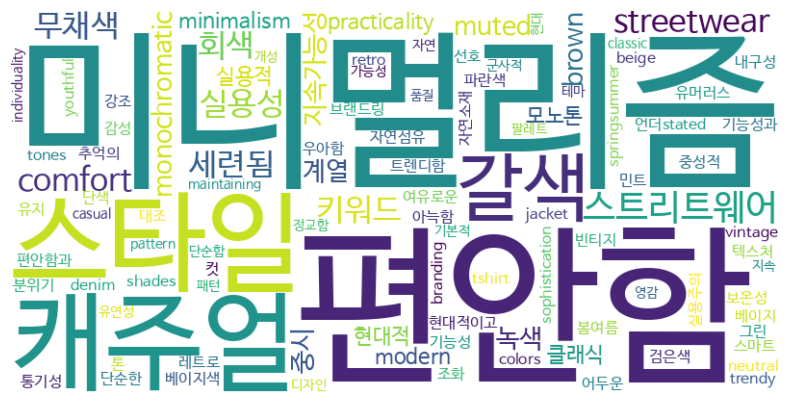

In [30]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [31]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url: {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이고 명확하게 작성해주세요. 문서 형식은 markdown이고, 예시 이미지를 포함해주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:30<00:00, 30.57s/it, est. speed input: 77.99 toks/s, output: 39.98 toks/s]


In [32]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))   # markdown을 html로 변환해서 표시

# 해외 룩북 스타일 분석 보고서

## 개요
본 보고서는 최근 공개된 여러 해외 패션 룩북에서 관찰되는 주요 트렌드를 종합적으로 분석한 내용입니다. 각 룩북에서 포착된 스타일 요소들은 현대 패션의 방향성을 반영하며, 특히 편안함과 실용성, 그리고 지속 가능성에 중점을 둔 경향을 확인할 수 있습니다.

## 트렌드 분석

### 1. **미니멀리즘과 실용성의 결합**
- **예시 이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/undecorated-fall-winter-2025-collection-lookbook-13-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/undecorated-fall-winter-2025-collection-lookbook-13-1024x683.jpg)
  - **스타일 특징**: 중성적인 톤과 단순한 컷으로 구성된 캐주얼한 미니멀리즘 스타일.
  - **트렌드**: 편안함과 스타일의 균형을 추구하며, 계절에 상관없이 유연하게 착용 가능한 아이템들이 주를 이룬다.

### 2. **스트리트웨어와 고전적 요소의 융합**
- **예시 이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/johnbull-fall-winter-2025-collection-lookbook-01-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/johnbull-fall-winter-2025-collection-lookbook-01-1024x683.jpg)
  - **스타일 특징**: 스트리트웨어 요소와 고전적인 디자인의 조화.
  - **트렌드**: 현대적인 스트리트웨어의 영향 아래에서도 고전적인 요소를 통해 고급스러움을 부여하는 경향이 두드러진다.

### 3. **지속 가능성과 자연 친화적 소재**
- **예시 이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/invincible-clarks-originals-fall-winter-2025-wallabee-14-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/invincible-clarks-originals-fall-winter-2025-wallabee-14-1024x683.jpg)
  - **스타일 특징**: 자연 소재와 친환경적인 디자인 강조.
  - **트렌드**: 환경 친화적인 소재 사용과 함께 실용성과 스타일을 동시에 추구하는 경향이 증가하고 있다.

### 4. **실용성과 편안함의 강조**
- **예시 이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/superthanks-fall-winter-2025-collection-lookbook-02-1024x682.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/superthanks-fall-winter-2025-collection-lookbook-02-1024x682.jpg)
  - **스타일 특징**: 실용적인 디자인과 편안한 착용감을 중시하는 스타일.
  - **트렌드**: 일상 생활과 활동성을 고려한 편안하면서도 세련된 의류 선택이 주를 이룬다.

### 5. **군사적 요소와 현대적 해석**
- **예시 이미지**: [https://glltn.com/wp-content/blogs.dir/1/files/2025/11/warobe-fall-winter-2025-collection-lookbook-08-1024x683.jpg](https://glltn.com/wp-content/blogs.dir/1/files/2025/11/warobe-fall-winter-2025-collection-lookbook-08-1024x683.jpg)
  - **스타일 특징**: 군사적 디자인 요소와 현대적 감각의 결합.
  - **트렌드**: 전통적인 군사적 요소를 현대적이고 편안한 방식으로 재해석하여 새로운 패션 트렌드를 창출하고 있다.

## 결론
최근 패션 트렌드는 편안함과 실용성을 중심으로 하면서도, 미니멀리즘과 지속 가능성에 대한 관심이 높아지고 있습니다. 이러한 경향은 다양한 문화적 요소와 현대적 해석을 통해 더욱 다채롭게 발전하고 있으며, 소비자들은 이러한 요소들을 통해 개인의 스타일을 표현하면서도 환경과의 조화를 추구하고 있습니다. 이러한 분석은 패션 산업이 미래에 어떻게 진화할지에 대한 중요한 통찰을 제공합니다.